# 04 - evaluation

https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/04-evaluation/homework.md

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')
print(df.shape)
df.head()

(1319, 12)


,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
# let's see the data
for i, col in enumerate(df.columns):
    print(f'{i} {col} \t{df[col].dtype} \t {df[col].nunique()}')
    print('\t',df[col].unique()[:5])
    print()

0 card 	object 	 2
	 ['yes' 'no']

1 reports 	int64 	 13
	 [0 7 3 1 2]

2 age 	float64 	 418
	 [37.66667 33.25    33.66667 30.5     32.16667]

3 income 	float64 	 431
	 [4.52   2.42   4.5    2.54   9.7867]

4 share 	float64 	 1162
	 [0.03326991 0.00521694 0.00415556 0.06521378 0.06705059]

5 expenditure 	float64 	 981
	 [124.9833     9.854167  15.       137.8692   546.5033  ]

6 owner 	object 	 2
	 ['yes' 'no']

7 selfemp 	object 	 2
	 ['no' 'yes']

8 dependents 	int64 	 7
	 [3 4 0 2 1]

9 months 	int64 	 193
	 [54 34 58 25 64]

10 majorcards 	int64 	 2
	 [1 0]

11 active 	int64 	 35
	 [12 13  5  7  1]



### Preparation

In [5]:
# Create the target variable by mapping yes to 1 and no to 0.
df.card = (df.card == 'yes').astype(int)

In [6]:
# Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use train_test_split funciton for that with random_state=1
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=len(df_test), random_state=1)
df_train.shape, df_val.shape, df_test.shape

((791, 12), (264, 12), (264, 12))

In [7]:
y_train = df_train.pop('card')
y_val = df_val.pop('card')
y_test = df_test.pop('card')

# Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.


Let's do that

* For each numerical variable, use it as score and compute AUC with the card variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

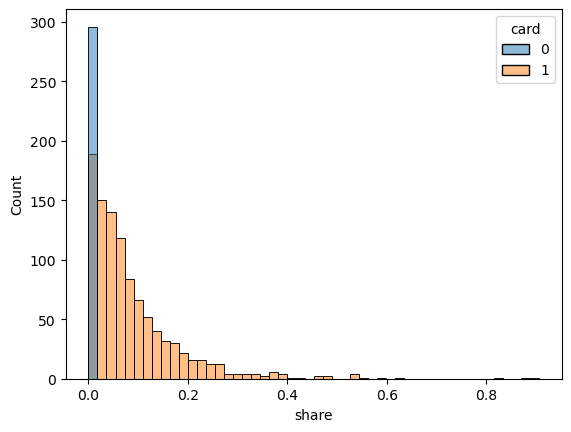

In [8]:
sns.histplot(data=df, x='share', hue='card', bins=50);

In [9]:
for col in ['reports', 'dependents', 'active', 'share']:
    score = roc_auc_score(df.card, df[col]).round(4)
    if score < 0.5:
        score = roc_auc_score(df.card, -df[col]).round(4)
    print('roc_auc', score, '\t', col)

roc_auc 0.7178 	 reports
roc_auc 0.5258 	 dependents
roc_auc 0.5825 	 active
roc_auc 0.9898 	 share


Answer: numerical variable __share__ has the highest AUC

### Training the model

In [10]:
# From now on, use these columns only:
columns = ["reports", "age", "income", 
           "share", "expenditure", "dependents", 
           "months", "majorcards", "active",
           "owner", "selfemp"]

In [11]:
# Apply one-hot-encoding using DictVectorizer 
train_dict = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_train.shape

(791, 13)

In [12]:
# train the logistic regression with these parameters:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

# Question 2

In [13]:
# What's the AUC of this model on the validation dataset? (round to 3 digits)
val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
X_val.shape

(264, 13)

In [14]:
y_pred_proba = model.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_pred_proba)
round(score,3)

0.995

Answer: 0.995

# Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall

Plot them

At which threshold precision and recall curves intersect?

In [15]:
thresholds = np.arange(0, 1.01, 0.01)
scores = []
for t in thresholds:
    
    y_pred = (y_pred_proba >= t).astype(int)

    tp = ((y_pred == 1) & (y_val == 1)).sum()
    tn = ((y_pred == 0) & (y_val == 0)).sum()
    fp = ((y_pred == 1) & (y_val == 0)).sum()
    fn = ((y_pred == 0) & (y_val == 1)).sum() 
    
    scores.append([t, tp, tn, fp, fn])
    
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'tn', 'fp', 'fn'])
df_scores['p'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])
df_scores['r'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
df_scores[::10] 

,threshold,tp,tn,fp,fn,p,r
0,0.0,211,0,53,0,0.799242,1.000000
10,0.1,210,36,17,1,0.925110,0.995261
20,0.2,207,48,5,4,0.976415,0.981043
30,0.3,205,48,5,6,0.976190,0.971564
40,0.4,205,52,1,6,0.995146,0.971564
50,0.5,204,52,1,7,0.995122,0.966825
60,0.6,204,52,1,7,0.995122,0.966825
70,0.7,204,52,1,7,0.995122,0.966825
80,0.8,204,52,1,7,0.995122,0.966825
90,0.9,204,53,0,7,1.000000,0.966825


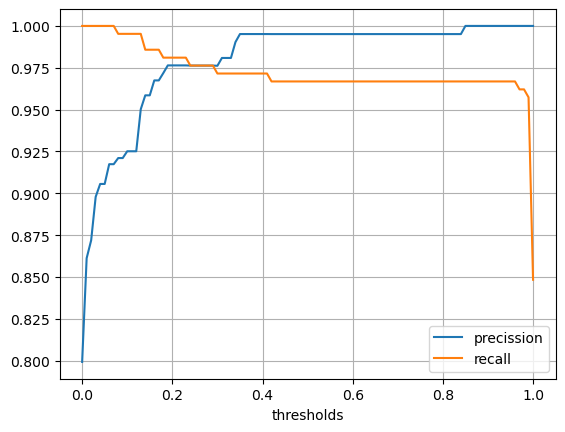

In [16]:
plt.plot(thresholds, df_scores.p, label='precission')
plt.plot(thresholds, df_scores.r, label='recall')
plt.xlabel("thresholds")
plt.grid()
plt.legend();

Answer: At __0.3__ threshold precision and recall curves intersect

# Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [17]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

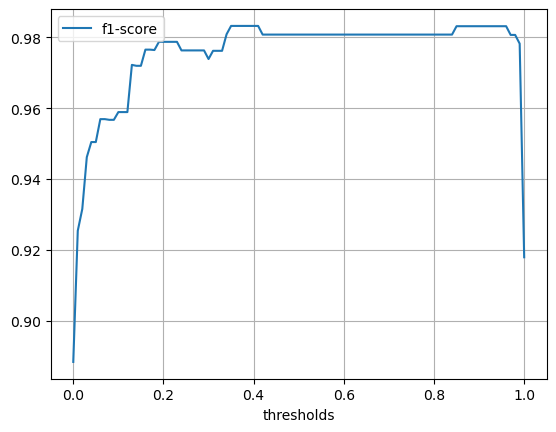

In [18]:
plt.plot(thresholds, df_scores.f1, label='f1-score')
plt.xlabel("thresholds")
plt.grid()
plt.legend();

Answer: At __0.4__ threshold F1 is maximal 

# Question 5

In [19]:
# Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

In [20]:
def train(df_train, y_train, C=1.0):
    
    dicts = df_train[columns].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model    

In [21]:
def predict_proba(df, dv, model):
    
    dicts = df[columns].to_dict(orient='records')
    X = dv.transform(dicts)
    
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    return y_pred_proba  

In [22]:
scores = []
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    dv, model = train(df_train, y_train)
    y_pred_proba = predict_proba(df_val, dv, model)
        
    score = roc_auc_score(y_val, y_pred_proba)    
    scores.append(score)
    
print(f'roc_auc: {np.mean(scores).round(3)} +- {np.std(scores).round(3)}')

roc_auc: 0.996 +- 0.003


Answer: __0.003__ devidation of the AUC scores across different folds

# Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [23]:
for C in [0.01, 0.1, 1, 10]:
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    scores = []
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred_proba = predict_proba(df_val, dv, model)

        score = roc_auc_score(y_val, y_pred_proba)    
        scores.append(score)

    print(f'for C={C} \t roc_auc: {np.mean(scores).round(3)} +- {np.std(scores).round(3)}')
    

for C=0.01 	 roc_auc: 0.992 +- 0.006
for C=0.1 	 roc_auc: 0.995 +- 0.004
for C=1 	 roc_auc: 0.996 +- 0.003
for C=10 	 roc_auc: 0.996 +- 0.003


In [25]:
# If you have ties, select the score with the lowest std. If you still have ties, select the smallest C
Answer: C=1